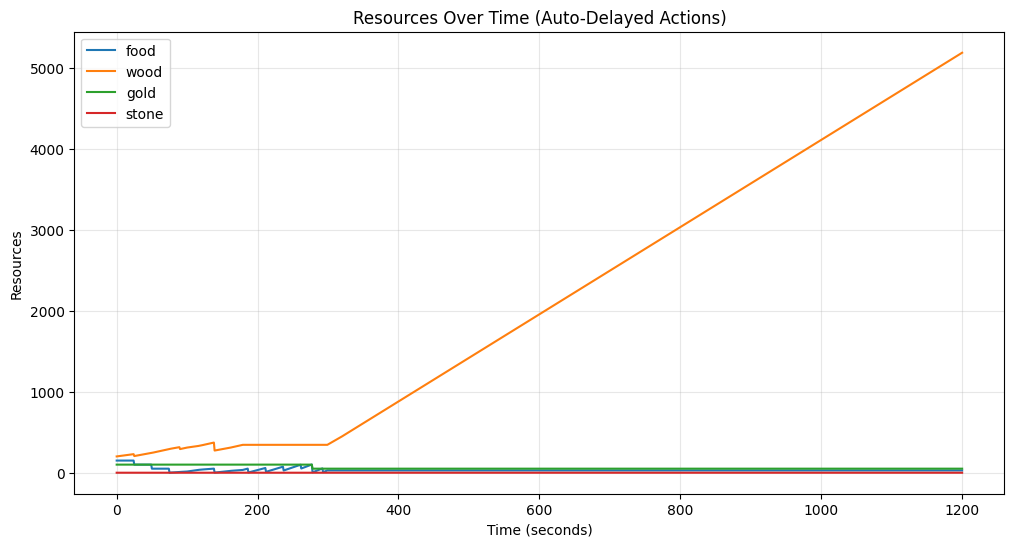

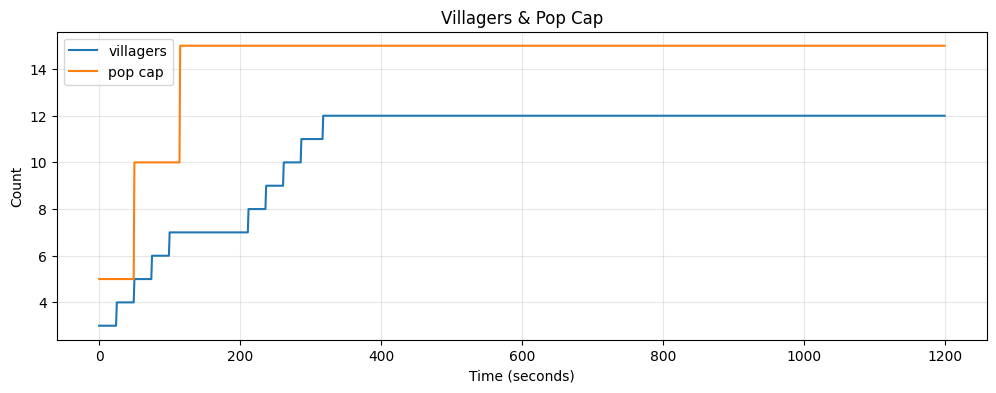

Delayed actions:
{'name': 'Double-Bit Axe (example)', 'planned_start': 120, 'actual_start': 139, 'delay_seconds': 19}
{'name': 'Some knowledge research', 'planned_start': 220, 'actual_start': 278, 'delay_seconds': 58}


In [ ]:
# --- AoE2 Economy Simulator (Option B: auto-delay actions until affordable) ---
# Paste this into a Jupyter notebook cell (or split into cells). Uses matplotlib for plots.

from __future__ import annotations

from dataclasses import dataclass, field
from typing import Dict, List, Callable, Optional, Tuple, Any
import math
import matplotlib.pyplot as plt

RESOURCES = ("food", "wood", "gold", "stone")


# ----------------------------
# Data structures
# ----------------------------
@dataclass
class Bundle:
    """Resource bundle (food/wood/gold/stone)."""
    food: float = 0.0
    wood: float = 0.0
    gold: float = 0.0
    stone: float = 0.0

    def as_dict(self) -> Dict[str, float]:
        return {r: float(getattr(self, r)) for r in RESOURCES}

    @staticmethod
    def from_dict(d: Dict[str, float]) -> "Bundle":
        return Bundle(**{r: float(d.get(r, 0.0)) for r in RESOURCES})

    def __add__(self, other: "Bundle") -> "Bundle":
        return Bundle.from_dict({r: self.as_dict()[r] + other.as_dict()[r] for r in RESOURCES})

    def __sub__(self, other: "Bundle") -> "Bundle":
        return Bundle.from_dict({r: self.as_dict()[r] - other.as_dict()[r] for r in RESOURCES})


# ----------------------------
# Actions: buildings, techs, age-ups
# ----------------------------
@dataclass(order=True)
class Action:
    t_start: int
    name: str = field(compare=False)
    cost: Bundle = field(default_factory=Bundle, compare=False)
    duration: int = field(default=0, compare=False)

    def t_end(self) -> int:
        return self.t_start + self.duration

    def on_start(self, sim: "Simulator") -> None:
        sim.spend(self.cost, reason=f"Start {self.name}")

    def on_complete(self, sim: "Simulator") -> None:
        pass


@dataclass(order=True)
class Build(Action):
    building: str = field(default="", compare=False)
    effect: Dict[str, Any] = field(default_factory=dict, compare=False)
    # effect examples:
    # {"pop_cap": +5}
    # {"town_centers": +1}

    def on_complete(self, sim: "Simulator") -> None:
        sim.buildings[self.building] = sim.buildings.get(self.building, 0) + 1
        if "pop_cap" in self.effect:
            sim.pop_cap += int(self.effect["pop_cap"])
        if "town_centers" in self.effect:
            sim.town_centers += int(self.effect["town_centers"])


@dataclass(order=True)
class Tech(Action):
    gather_multiplier: Dict[str, float] = field(default_factory=dict, compare=False)

    def on_complete(self, sim: "Simulator") -> None:
        for r, m in self.gather_multiplier.items():
            sim.gather_mult[r] *= float(m)


@dataclass(order=True)
class Knowledge(Action):
    def on_complete(self, sim: "Simulator") -> None:
        pass


@dataclass(order=True)
class AgeUp(Action):
    target_age: str = field(default="", compare=False)

    def on_start(self, sim: "Simulator") -> None:
        super().on_start(sim)
        sim.age_up_windows.append((self.t_start, self.t_end()))
        sim.age = self.target_age  # set on start (you can move to completion if preferred)


# ----------------------------
# Simulator
# ----------------------------
@dataclass
class SimConfig:
    t_end: int = 2000

    starting_resources: Bundle = field(default_factory=lambda: Bundle(food=200, wood=200, gold=100, stone=0))
    starting_villagers: int = 3
    starting_pop_cap: int = 5

    vill_cost: Bundle = field(default_factory=lambda: Bundle(food=50))
    vill_train_time: int = 25
    town_centers: int = 1

    # Placeholder gather rates per vill per second (tune these!)
    base_gather_rate: Dict[str, float] = field(default_factory=lambda: {
        "food": 0.37,
        "wood": 0.39,
        "gold": 0.38,
        "stone": 0.36,
    })

    maximize_weights: Dict[str, float] = field(default_factory=lambda: {
        "food": 1.0, "wood": 1.0, "gold": 0.9, "stone": 0.2
    })

    lookahead_seconds: int = 120


History = Dict[str, List[float]]


class Simulator:
    def __init__(
        self,
        config: SimConfig,
        actions: List[Action],
        assignment_policy: Optional[Callable[["Simulator"], Dict[str, int]]] = None,
        enable_action_delay_log: bool = True,
    ):
        self.cfg = config
        self.actions = sorted(actions, key=lambda a: a.t_start)

        # State
        self.t = 0
        self.res = self.cfg.starting_resources.as_dict()
        self.villagers = int(self.cfg.starting_villagers)
        self.pop_cap = int(self.cfg.starting_pop_cap)
        self.town_centers = int(self.cfg.town_centers)
        self.age = "Dark"

        self.buildings: Dict[str, int] = {}
        self.gather_mult = {r: 1.0 for r in RESOURCES}
        self.age_up_windows: List[Tuple[int, int]] = []

        # Villager training pipeline: list of completion times
        self._vill_queue: List[int] = []

        # Action bookkeeping (Option B):
        # schedule starts by planned time; schedule completions only when actually started.
        self._actions_starting_at: Dict[int, List[Action]] = {}
        self._actions_completing_at: Dict[int, List[Action]] = {}
        for a in self.actions:
            self._actions_starting_at.setdefault(a.t_start, []).append(a)

        self._delayed_actions: List[Action] = []
        self._planned_start: Dict[int, int] = {id(a): a.t_start for a in self.actions}

        self.assignment_policy = assignment_policy or self.default_policy
        self.enable_action_delay_log = enable_action_delay_log
        self.action_delay_log: List[Dict[str, Any]] = []

        # History
        self.hist: History = {"t": [], **{r: [] for r in RESOURCES}, "vills": [], "pop_cap": []}

    # ---------- Utility ----------
    def can_afford(self, cost: Bundle) -> bool:
        c = cost.as_dict()
        return all(self.res[r] + 1e-9 >= c[r] for r in RESOURCES)

    def spend(self, cost: Bundle, reason: str = "") -> None:
        c = cost.as_dict()
        for r in RESOURCES:
            if self.res[r] + 1e-9 < c[r]:
                raise RuntimeError(
                    f"Insufficient {r} at t={self.t} for '{reason}'. Need {c[r]:.1f}, have {self.res[r]:.1f}."
                )
        for r in RESOURCES:
            self.res[r] -= c[r]

    def in_age_up(self, t: int) -> bool:
        return any(start <= t < end for start, end in self.age_up_windows)

    def current_gather_rate(self, resource: str) -> float:
        return self.cfg.base_gather_rate[resource] * self.gather_mult[resource]

    def upcoming_costs_within(self, horizon: int) -> Bundle:
        end_t = self.t + horizon
        total = {r: 0.0 for r in RESOURCES}
        for a in self.actions:
            if self.t < a.t_start <= end_t:
                c = a.cost.as_dict()
                for r in RESOURCES:
                    total[r] += c[r]
        return Bundle.from_dict(total)

    # ---------- Villager production ----------
    def try_start_villagers(self) -> None:
        """Always produce villagers except during age-up, subject to pop cap & food."""
        if self.in_age_up(self.t):
            return

        in_progress = sum(1 for ct in self._vill_queue if ct > self.t)
        free_slots = max(0, self.town_centers - in_progress)

        for _ in range(free_slots):
            training = sum(1 for ct in self._vill_queue if ct > self.t)
            if self.villagers + training >= self.pop_cap:
                break
            try:
                self.spend(self.cfg.vill_cost, reason="Train villager")
            except RuntimeError:
                break
            self._vill_queue.append(self.t + self.cfg.vill_train_time)

    def complete_villagers(self) -> None:
        completed = sum(1 for ct in self._vill_queue if ct == self.t)
        if completed:
            self.villagers += completed
        self._vill_queue = [ct for ct in self._vill_queue if ct > self.t]

    # ---------- Assignment policy ----------
    def default_policy(self) -> Dict[str, int]:
        """
        Greedy policy:
        - Allocate villagers to cover projected deficits for upcoming action start-costs within lookahead.
        - Put remaining villagers into resource maximizing weight*rate.
        """
        horizon = self.cfg.lookahead_seconds
        upcoming = self.upcoming_costs_within(horizon).as_dict()

        deficits = {r: max(0.0, upcoming[r] - self.res[r]) for r in RESOURCES}
        rates = {r: self.current_gather_rate(r) for r in RESOURCES}

        assignments = {r: 0 for r in RESOURCES}
        remaining = self.villagers

        need = []
        for r in RESOURCES:
            if deficits[r] <= 0 or rates[r] <= 0:
                continue
            v = math.ceil(deficits[r] / max(1e-9, rates[r] * horizon))
            if v > 0:
                need.append((r, v))

        need.sort(key=lambda x: deficits[x[0]], reverse=True)
        for r, v in need:
            take = min(remaining, v)
            assignments[r] += take
            remaining -= take

        if remaining > 0:
            best_r = max(
                RESOURCES,
                key=lambda r: self.cfg.maximize_weights.get(r, 0.0) * rates[r],
            )
            assignments[best_r] += remaining

        return assignments

    def _normalize_assignments(self, assign: Dict[str, int]) -> Dict[str, int]:
        total = sum(assign.get(r, 0) for r in RESOURCES)
        if total == self.villagers:
            return {r: int(assign.get(r, 0)) for r in RESOURCES}

        if total <= 0:
            out = {r: 0 for r in RESOURCES}
            out["food"] = self.villagers
            return out

        factor = self.villagers / total
        out = {r: int(math.floor(assign.get(r, 0) * factor)) for r in RESOURCES}
        diff = self.villagers - sum(out.values())
        if diff > 0:
            best_r = max(RESOURCES, key=lambda r: self.current_gather_rate(r))
            out[best_r] += diff
        return out

    # ---------- Main loop ----------
    def step(self) -> None:
        # 1) Complete actions finishing now
        for a in self._actions_completing_at.get(self.t, []):
            a.on_complete(self)

        # 2) Complete villagers finishing now
        self.complete_villagers()

        # 3) Start actions due now OR delayed until affordable (Option B)
        due_now = self._actions_starting_at.get(self.t, [])
        to_try = self._delayed_actions + due_now
        self._delayed_actions = []

        for a in to_try:
            if self.can_afford(a.cost):
                planned = self._planned_start.get(id(a), a.t_start)
                actual = self.t

                # Shift actual start time for correct completion scheduling
                a.t_start = actual

                if self.enable_action_delay_log and actual != planned:
                    self.action_delay_log.append({
                        "name": a.name,
                        "planned_start": planned,
                        "actual_start": actual,
                        "delay_seconds": actual - planned,
                    })

                a.on_start(self)

                if a.duration == 0:
                    a.on_complete(self)
                else:
                    self._actions_completing_at.setdefault(a.t_end(), []).append(a)
            else:
                self._delayed_actions.append(a)

        # 4) Start villager training (always, except in age-up)
        self.try_start_villagers()

        # 5) Assign villagers and gather resources
        assign = self._normalize_assignments(self.assignment_policy())
        for r in RESOURCES:
            self.res[r] += assign[r] * self.current_gather_rate(r)

        # 6) Record history
        self.hist["t"].append(self.t)
        for r in RESOURCES:
            self.hist[r].append(self.res[r])
        self.hist["vills"].append(self.villagers)
        self.hist["pop_cap"].append(self.pop_cap)

        self.t += 1

    def run(self) -> History:
        while self.t <= self.cfg.t_end:
            self.step()
        return self.hist


# ----------------------------
# Plotting helpers
# ----------------------------
def plot_resources(hist: History, title: str = "AoE2 Economy Simulation"):
    t = hist["t"]
    plt.figure(figsize=(12, 6))
    for r in RESOURCES:
        plt.plot(t, hist[r], label=r)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Resources")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_population(hist: History, title: str = "Villagers & Pop Cap"):
    t = hist["t"]
    plt.figure(figsize=(12, 4))
    plt.plot(t, hist["vills"], label="villagers")
    plt.plot(t, hist["pop_cap"], label="pop cap")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# ----------------------------
# Example usage (edit timeline + rates!)
# ----------------------------
cfg = SimConfig(
    t_end=1200,
    base_gather_rate={
        "food": 0.33,
        "wood": 0.39,
        "gold": 0.38,
        "stone": 0.36,
    },
    lookahead_seconds=120,
)

actions: List[Action] = [
    Build(t_start=25, name="House #1", cost=Bundle(wood=25), duration=25, building="house", effect={"pop_cap": +5}),
    Build(t_start=90, name="House #2", cost=Bundle(wood=25), duration=25, building="house", effect={"pop_cap": +5}),
    Tech(
        t_start=120,
        name="Double-Bit Axe (example)",
        cost=Bundle(wood=100, food=50),
        duration=40,
        gather_multiplier={"wood": 1.15},
    ),
    Knowledge(t_start=220, name="Some knowledge research", cost=Bundle(food=100, gold=50), duration=30),
    AgeUp(t_start=300, name="Feudal Age", cost=Bundle(food=500), duration=130, target_age="Feudal"),
]

sim = Simulator(cfg, actions, enable_action_delay_log=True)
hist = sim.run()

plot_resources(hist, title="Resources Over Time (Auto-Delayed Actions)")
plot_population(hist)

# If you want to see what slipped:
if sim.action_delay_log:
    print("Delayed actions:")
    for row in sim.action_delay_log:
        print(row)
else:
    print("No delayed actions.")
